# Question 1: What are the most popular Airbnb locations in Berlin?
The first question around the Airbnb Berlin data set is about identifying __areas of the city that are more popular than others__. The results may work as __guidance__ for people who are interested in __renting out apartments__ either privately or professionally.

The __five steps__ involved in this notebook are as follows:
* 1 - Load libraries
* 2 - Import & understand data
* 3 - Pre-process data
* 4 - Model data
* 5 - Analyze data & evaluate results

## 1 - Load Libraries

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## 2 - Import & Understand Data

In [138]:
# Import listings data (Source: http://insideairbnb.com/get-the-data.html)
df_listings = pd.read_csv('../data/listings_berlin.csv')

# Preview data
print(df_listings.shape)
pd.options.display.max_columns = None
df_listings.head(1)

(22572, 96)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20180912025131,2018-09-12,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,"This is my home, not a hotel. I rent out occas...","Close to U-Bahn U8 and U2 (metro), Trams M12, ...","Simple kitchen/cooking, refrigerator, microwav...",Always available,"No parties No events No pets No smoking, not e...",NaN,NaN,https://a0.muscache.com/im/pictures/260fd609-7...,NaN,2217,https://www.airbnb.com/users/show/2217,Ian,2008-08-18,"Key Biscayne, Florida, United States",Believe in sharing economy.,within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/21428a22-4...,https://a0.muscache.com/im/pictures/21428a22-4...,Mitte,3.0,3.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Berlin, Berlin, Germany",Mitte,Brunnenstr. Süd,Mitte,Berlin,Berlin,10119,Berlin,"Berlin, Germany",DE,Germany,52.534537,13.402557,f,Guesthouse,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",NaN,$60.00,NaN,NaN,$200.00,$30.00,1,$28.00,4,1125,6 weeks ago,t,5,34,64,154,2018-09-12,109,2016-04-11,2018-09-08,92.0,9.0,9.0,10.0,10.0,10.0,9.0,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,3,3.69


### 2.1 - Overview
There are multiple columns in the data set that appear to be very useful for answering the question posed at the beginning of this notebook. However, before comparing different areas of Berlin with each other it's important to __define the term "popularity"__. In particular, the popularity of an area is influenced by __two main features__, whereas an increase in each of them increases popularity and vice versa. These feature are:

* The __number of apartments__
* The __occupancy of apartments__

__Attributes__ in the Airbnb data set that can be used to __estimate__ the popularity of different areas are:
* neighbourhood_group_cleansed
* minimum_nights, reviews_per_month

## 3 - Pre-Process Data

Before starting to model the data it's important to pay close attention to the columns that need to be used and pre-process them or the data set where necessary.

### 3.1 - Property Types

In [139]:
# Check distriution of property types
property_count = df_listings["property_type"].value_counts().sum()
print((df_listings["property_type"].value_counts().sort_values(ascending=False) / property_count).head())

# Number of unique property types
print("\nThere are {} unique property types within the data set.".format(len(df_listings["property_type"].unique())))

Apartment             0.900097
Condominium           0.026715
Loft                  0.018740
House                 0.018120
Serviced apartment    0.008462
Name: property_type, dtype: float64

There are 33 unique property types within the data set.


The __22,572 Airbnb listings__ in Berlin can be mapped to __33 different property types__, with __90% of all property types actually being apartments__. As I am mainly interested in apartments I am going to remove all listing with property types other than "Apartment".

In [140]:
# Keep only apartments in analysis
n_all = df_listings.shape[0]
df_listings = df_listings[df_listings["property_type"] == "Apartment"]
print("{} records were removed from the Airbnb Berlin listings data frame.".format(n_all - df_listings.shape[0]))

2255 records were removed from the Airbnb Berlin listings data frame.


Now that we've removed all property types other than apartments, it's time to __check for missing values__ in the columns that need to used for a popularity comparison of areas.

### 3.2 - Missing Values

In [164]:
# Check for missing values
df_listings[["neighbourhood_group_cleansed","minimum_nights","reviews_per_month"]].isnull().sum()

neighbourhood_group_cleansed    0
minimum_nights                  0
reviews_per_month               0
dtype: int64

It looks like the column __"reviews_per_month"__ has __missing values__. If a listing has never received any reviews before than we should probably set the value for "reviews_per_month" to 0.

In [165]:
# Impute missing values
df_listings["reviews_per_month"] = df_listings["reviews_per_month"].fillna(0)

# Check for missing values
df_listings[["reviews_per_month"]].isnull().sum()

reviews_per_month    0
dtype: int64

The column "neighbourhood_group_cleansed" stores information on the area a listing is located in. Let's look at it's values:

### 3.3 - Neighbourhoods

In [143]:
# Check distriution of neighbourhood groups
hood_count = df_listings["neighbourhood_group_cleansed"].value_counts().sum()
print((df_listings["neighbourhood_group_cleansed"].value_counts().sort_values(ascending=False) / hood_count))

# Number of unique neighbourhood groups
print("\nThere are {} unique neighbourhood groups types within the data set.".format(len(df_listings["neighbourhood_group_cleansed"].unique())))

Friedrichshain-Kreuzberg    0.252252
Mitte                       0.203918
Neukölln                    0.163853
Pankow                      0.158045
Charlottenburg-Wilm.        0.069055
Tempelhof - Schöneberg      0.068120
Lichtenberg                 0.028105
Treptow - Köpenick          0.023527
Steglitz - Zehlendorf       0.016489
Reinickendorf               0.009992
Spandau                     0.003741
Marzahn - Hellersdorf       0.002904
Name: neighbourhood_group_cleansed, dtype: float64

There are 12 unique neighbourhood groups types within the data set.


The __22,572 Airbnb listings__ are located in __12 different neighbourhood groups, with __23% of all listings actually being in Friedrichshain-Kreuzberg__. I'm not too happy with the text formatting of values so I'm going to adjust it slighty.

In [144]:
# Adjust values of "neighbourhood_group_cleansed"
df_listings["neighbourhood_group_cleansed"] = df_listings["neighbourhood_group_cleansed"].astype(str).str.replace("Charlottenburg-Wilm.", "Charlottenburg-Wilmersdorf")
df_listings["neighbourhood_group_cleansed"] = df_listings["neighbourhood_group_cleansed"].astype(str).str.replace(" ", "")

## 4 - Model Data

The analysis of an area's popularity on Airbnb is focused around __two main features__, namely the number of apartments in a particular area as well as the occupancy of individual apartments. Unfortunately, the data set doesn't provide all this information for us ready to use. Thus, we need to come up with __a way to model the data__.

### 4.1 - Number of Apartments

In [145]:
# Number of listings / neighbourhood group
hood_count = df_listings[["neighbourhood_group_cleansed","id"]]
hood_count = hood_count.groupby("neighbourhood_group_cleansed", as_index=False).agg("count")
hood_count.columns = ["neighbourhood_group", "num_listings"]
hood_count.head()

,neighbourhood_group,num_listings
0,Charlottenburg-Wilmersdorf,1403
1,Friedrichshain-Kreuzberg,5125
2,Lichtenberg,571
3,Marzahn-Hellersdorf,59
4,Mitte,4143


In [146]:
# Average listings count / neighbourhood
hood_count["num_listings"].mean()

1693.0833333333333

The number of apartments in each neighbourhood group can be easily calculated. On average there are __1,693 listings located in each of them__. However, neighbourhood groups with larger areas (measured in km2) tend to have more Airbnb listings and vice versa. Thus, we need to __account for the size of the area of a neighbourhood group__ when making comparisons on the number of listings.

In [147]:
# Data frame with area in square kilometre / neighbourhood groups
# Source: https://de.wikipedia.org/wiki/Liste_der_Bezirke_und_Ortsteile_Berlins
hood_names = ['Pankow','Tempelhof-Schöneberg','Friedrichshain-Kreuzberg','Neukölln','Mitte','Charlottenburg-Wilmersdorf',
              'Treptow-Köpenick','Lichtenberg','Reinickendorf','Steglitz-Zehlendorf','Marzahn-Hellersdorf','Spandau']
hood_size = [103.01,53.09,20.16,44.93,39.47,103.01,168.42,52.29,89.46,102.50,61.74,91.91]
hood_area = pd.DataFrame({"neighbourhood_group": hood_names, "area_km2": hood_size})
hood_area = hood_area.sort_values("neighbourhood_group").reset_index(drop=True)
hood_area.head()

,neighbourhood_group,area_km2
0,Charlottenburg-Wilmersdorf,103.01
1,Friedrichshain-Kreuzberg,20.16
2,Lichtenberg,52.29
3,Marzahn-Hellersdorf,61.74
4,Mitte,39.47


In [148]:
# Add listing density to neighbourhood counts
hood_count["num_listings_per_km2"] = hood_count["num_listings"] / hood_area["area_km2"]

### 4.2 - Occupancy

Variables with direct influence on the occupancy of an Airbnb apartment are the duration and the frequency of bookings. Unfortunately, the data set doesn't have information on either of these. When we assume that people who book apartments on Airbnb always leave a review, we can simply use the column "reviews_per_month" as a proxy for booking frequency. I've also capped the booking frequency so it can't exceed the maximum number of bookings per month based on the minimum nights.

In [151]:
# Define adjusted proxy for number of bookings per months
df_listings["max_bookings_per_month"] = (30.42 / df_listings["minimum_nights"]).fillna(0)
df_listings["bookings_per_month"] = df_listings[["max_bookings_per_month","reviews_per_month"]].min(axis=1)
df_listings = df_listings.drop("max_bookings_per_month", axis=1)

df_listings["bookings_per_month"].describe()

count    20317.000000
mean         0.885989
std          1.337913
min          0.000000
25%          0.060000
50%          0.330000
75%          1.080000
max         14.790000
Name: bookings_per_month, dtype: float64

Based on the previously adjusted booking frequency we can now calculate the occupancy. This relies on the assumption that each booking spans for a minimum/maximum period equal to the number of minimum nights.

In [152]:
# Calculate the monthly occupancy rate for each listing
df_listings["occupancy_rate"] = (df_listings["bookings_per_month"] * df_listings["minimum_nights"] / 30.42).fillna(0)
df_listings["occupancy_rate"].describe()

count    20317.000000
mean         0.091688
std          0.160096
min          0.000000
25%          0.005260
50%          0.032873
75%          0.106509
max          1.000000
Name: occupancy_rate, dtype: float64

In [166]:
# Create data frame with occupancy rate and listing density for each neighbourhood
# Grouping functions
f = {"id":["count"], "occupancy_rate":["mean"]}

# Grouping data
hood_occupancy = df_listings[["neighbourhood_group_cleansed","id","occupancy_rate"]]
hood_occupancy = hood_occupancy.groupby("neighbourhood_group_cleansed", as_index=False).agg(f)
hood_occupancy.columns = ["neighbourhood_group", "num_listings", "occupancy_rate"]
hood_occupancy = hood_occupancy.sort_values("neighbourhood_group")

# Calculate density
hood_occupancy["area_km2"] = hood_area["area_km2"]
hood_occupancy["listings_per_km2"] = hood_occupancy["num_listings"] / hood_occupancy["area_km2"]

## 5 - Analyze Data & Evaluate Results

### 5.1 - Number of Apartments

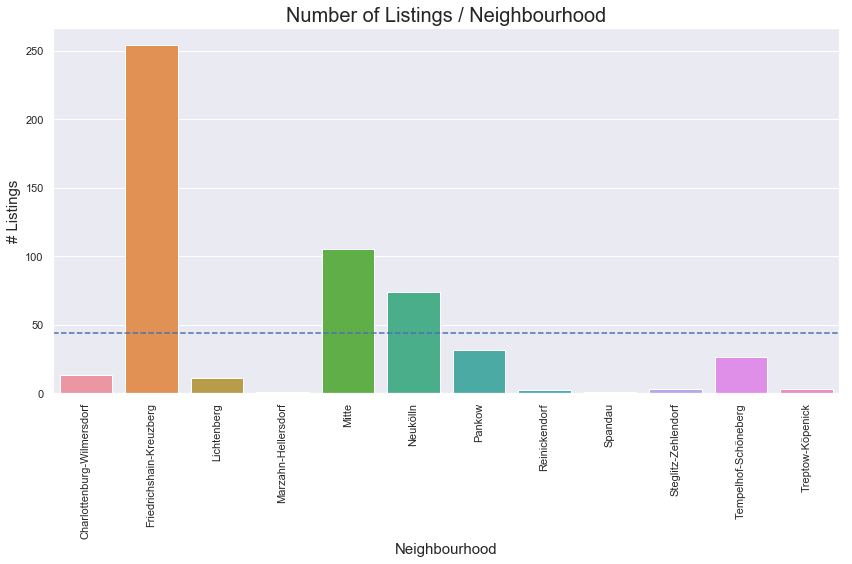

In [150]:
# Plot listing frequency / neighbourhood group 
plt.subplots(figsize=(12,8))
sns.set(style="darkgrid")
ax = sns.barplot(x="neighbourhood_group", y="num_listings_per_km2", data=hood_count)
plt.xticks(rotation=90);
plt.title("Number of Listings / Neighbourhood", fontsize=20)
plt.ylabel("# Listings", fontsize=15)
plt.xlabel("Neighbourhood", fontsize=15)
plt.tight_layout()

# Add median as reference line
ax.axhline(hood_count["num_listings_per_km2"].mean(), ls='--');

### 5.2 - Occupancy

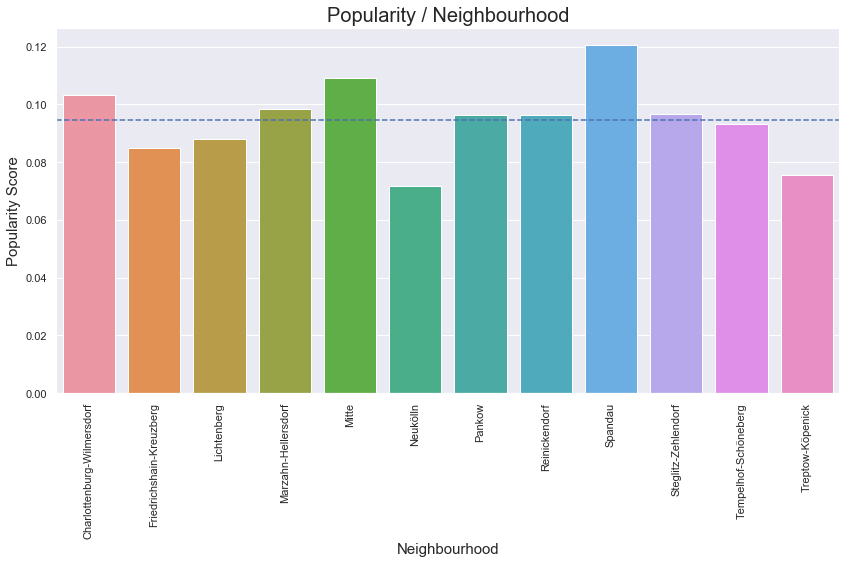

In [162]:
# Plot occupancy rate / neihbourhood group
plt.subplots(figsize=(12,8))
sns.set(style="darkgrid")
ax = sns.barplot(x="neighbourhood_group", y="occupancy_rate", data=hood_occupancy)
plt.xticks(rotation=90);
plt.title("Popularity / Neighbourhood", fontsize=20)
plt.ylabel("Popularity Score", fontsize=15)
plt.xlabel("Neighbourhood", fontsize=15)
plt.tight_layout()

# Add median as reference line
ax.axhline(hood_occupancy ["occupancy_rate"].mean(), ls='--');

### 5.3 - Popularity

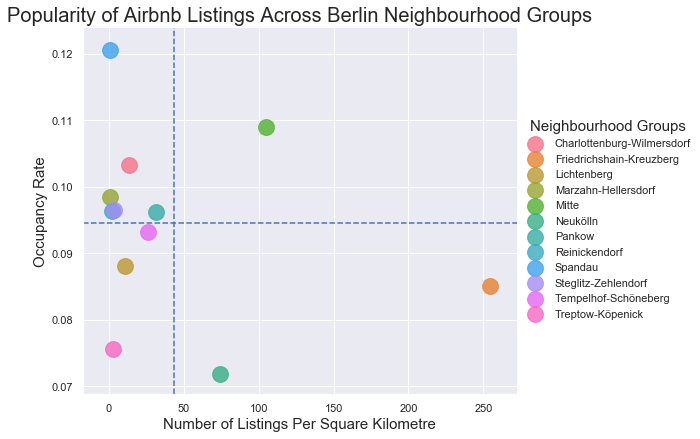

In [163]:
# Plot occupancy vs. listing count per square kilometre for neighbourhood groups
sns.set(style="darkgrid")
p = sns.lmplot("listings_per_km2", "occupancy_rate", data=hood_occupancy,
               hue="neighbourhood_group", fit_reg=False,
               height=6, aspect=1.2, scatter_kws={"s": 250})

# Add median as reference line
plt.axhline(hood_occupancy["occupancy_rate"].mean(), ls='--');
plt.axvline(hood_occupancy["listings_per_km2"].mean(), ls='--');

# Set labels
plt.title("Popularity of Airbnb Listings Across Berlin Neighbourhood Groups", fontsize=20)
plt.ylabel("Occupancy Rate", fontsize=15)
plt.xlabel("Number of Listings Per Square Kilometre", fontsize=15)
p._legend.set_title("Neighbourhood Groups")
plt.setp(p._legend.get_title(), fontsize=15);